In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
NOTE = '全特徴量を使用したLightGBM.バランス指定、カテゴリ指定'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '017'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

017_submission.csv 017


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  features=None) -> Pipeline:
    return Pipeline(steps=[
        ('estimator', LGBMClassifier(n_estimators=200,
                                     importance_type='gain',
                                     class_weight='balanced',
                                     objective='cross_entropy',
                                     learning_rate=0.01,
                                     random_state=SEED))
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam']

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator()
    clf.fit(X_train, y_train, estimator__feature_name=features, estimator__categorical_feature=categorical_features)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 1)**********
[[2388  994  697  387  345  171    7   77]
 [ 465 2283  413  256  186   91    8   44]
 [ 279  289 1360  197  175   63    4   26]
 [  26   35  114 1472   41   17    2    2]
 [   0    0    0    0  539    1    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[352 348 254 121 116  44   5  27]
 [205 364 166  85  63  38   2  13]
 [128 135 163  88  59  17   0   9]
 [ 37  35  93 186  43  20   3  10]
 [ 16  19  28  53  15   3   0   1]
 [  5   5   4  14   6   2   0   1]
 [  0   0   0   3   0   0   0   0]
 [  0   4   8   8   3   0   0   1]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 2)**********
[[2375  971  716  387  355  167   10   85]
 [ 435 2270  430  260  198   99    6   48]
 [ 286  299 1344  196  179   59    1   29]
 [  29   33  116 1467   43   18    1    2]
 [   0    0    1    0  538    0    1    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 2)**********
[[392 347 244 119  97  40   4  24]
 [206 393 133  86  74  27   2  15]
 [129 140 160  94  51  15   1   9]
 [ 43  48  91 187  43   9   0   6]
 [ 13  17  40  46  14   1   0   4]
 [  6   6   5  14   3   3   0   0]
 [  1   1   0   0   0   0   0   0]
 [  3   4   5   8   3   1   0   0]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 3)**********
[[2428  962  716  372  343  156    6   83]
 [ 447 2267  401  255  219  104    6   47]
 [ 294  307 1324  191  181   63    4   30]
 [  26   34  109 1472   45   19    1    2]
 [   0    0    2    0  538    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 3)**********
[[402 356 224 103 100  54   4  24]
 [230 381 132  86  56  35   2  14]
 [129 139 156  96  49  19   1   9]
 [ 28  40  94 196  51  16   1   2]
 [ 12  18  27  47  22   5   0   4]
 [  2   2   5  22   4   1   0   1]
 [  0   0   0   2   0   0   0   0]
 [  2   4   5   8   2   2   0   1]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 4)**********
[[2342  943  777  374  355  172   10   94]
 [ 451 2253  405  271  199  119    7   40]
 [ 274  338 1312  189  182   60    3   36]
 [  24   32  106 1481   48    7    3    8]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 4)**********
[[382 320 239 137 108  54   0  26]
 [199 358 147 115  65  29   3  21]
 [112 128 171  93  67  21   0   6]
 [ 40  39 111 159  59  14   0   5]
 [ 14  10  35  54  11   8   2   1]
 [  3   2   9  15   7   2   0   0]
 [  1   0   0   1   0   0   0   0]
 [  2   2   4   9   5   0   0   2]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


**********Confusion matrix for train set (Fold 5)**********
[[2364  965  754  385  344  160   11   84]
 [ 455 2292  417  241  193  100   10   37]
 [ 296  321 1317  175  191   63    3   28]
 [  24   33  110 1461   60   16    3    2]
 [   0    0    1    1  538    0    0    0]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 5)**********
[[388 362 216 136  91  44   0  29]
 [218 400 125  84  71  28   0  11]
 [127 122 159 103  57  17   0  13]
 [ 38  59  97 181  36  12   2   2]
 [ 19  15  20  63  15   3   0   0]
 [  5   7   6  13   6   1   0   0]
 [  0   1   0   1   0   0   0   0]
 [  1   3   5  11   3   1   0   0]]

Wall time: 9min 38s


In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.564111,0.189479
std,0.007021,0.005752
min,0.555452,0.183936
25%,0.558342,0.185809
50%,0.566662,0.187130
75%,0.567612,0.192453
max,0.572487,0.198069


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,1,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.095442,0.120859,0.392720,0.080353,0.244757,0.021680,0.021412,0.022777,27446,1
1,0.223173,0.122607,0.408799,0.159089,0.037923,0.016321,0.016010,0.016079,113,1
2,0.298125,0.346797,0.285454,0.022006,0.017412,0.010170,0.010016,0.010020,4479,1
3,0.301801,0.338742,0.288974,0.022277,0.017627,0.010296,0.010140,0.010143,29080,1
4,0.367397,0.189013,0.296799,0.064571,0.035630,0.015633,0.015454,0.015503,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.089732,0.188584,0.062515,0.552622,0.047070,0.019776,0.019716,0.019985,24272,5
33804,0.077751,0.375317,0.053924,0.403561,0.038037,0.017105,0.017018,0.017286,29106,5
33805,0.075741,0.353650,0.053568,0.426410,0.039562,0.016992,0.016906,0.017172,20679,5
33806,0.175868,0.357853,0.051990,0.330350,0.034619,0.016410,0.016327,0.016583,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,1.045134,1.908564,1.142994,0.274222,0.285145,0.166255,0.088664,0.089021
1,1,1.662868,2.132875,0.694793,0.145311,0.116196,0.129705,0.058229,0.060024
2,2,0.613669,0.496460,1.522992,1.184776,0.683317,0.177244,0.127743,0.193799
3,3,1.201935,1.495094,0.311635,1.408125,0.312800,0.090841,0.089421,0.090150
4,4,1.512623,1.857890,0.571750,0.169911,0.720383,0.060376,0.052273,0.054794
...,...,...,...,...,...,...,...,...,...
33803,33803,2.471608,0.405567,1.320246,0.228627,0.295780,0.104509,0.086426,0.087237
33804,33804,1.456075,1.042352,0.409159,1.320237,0.451267,0.104100,0.103112,0.113696
33805,33805,1.702000,1.317143,0.377300,0.954689,0.254412,0.117574,0.152800,0.124081
33806,33806,0.648010,0.705273,1.972886,0.686385,0.541932,0.164767,0.139636,0.141112


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.201816
1    0.379940
2    0.193238
3    0.197646
4    0.009672
5    0.011447
6    0.000562
7    0.005679
Name: y, dtype: float64

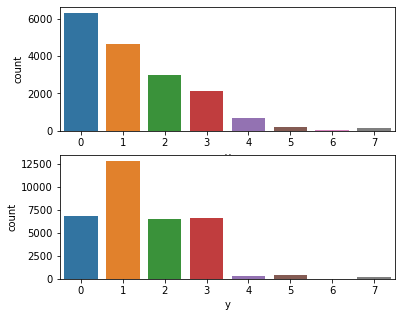

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.5641108878573368, 0.18947947476319477)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"017_submission.csv","Stratified-Kfold(K=5)","0.564111","0.189479","","全特徴量を使用したLightGBM.バランス指定、カテゴリ指定"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.39 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        else:
            feature_names = final_estimator.feature_names_
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 36.6 ms
